# Machine learning for image processing


## A short introduction to machine learning

This section is adapted from the [quick start tutorial](http://scikit-learn.org/stable/tutorial/basic/tutorial.html) from the scikit-learn documentation.

In general, a learning problem considers a set of N samples of data and then tries to predict properties of unknown data. If each sample is more than a single number and, for instance, a multi-dimensional entry (aka multivariate data), it is said to have several attributes or features.

Typical machine learning tasks are :
- **classification**: samples belong to two or more classes and we want to learn from already labeled data how to predict the class of unlabeled data. For example, given examples of pixels belonging to an object of interest and background, we want the algorithm to label all the other pixels of the image. Or given images of cats and dogs, we want to label automatically images whether they show cats or dogs. (_This notebook_)
- **clustering**: grouping together similar samples. For example, given a set of pictures, can we group them automatically by suject (e.g. people, monuments, animals...)?  (_See [clustering.ipynb](clustering.ipynb)_)

In image processing, a sample can either be
- a whole image, its features being pixel values, or sub-regions of an image (e.g. for face detection)
- a pixel, its features being intensity values in colorspace, or statistical information about a neighbourhood centered on the pixel,
- a labeled region, e.g. for classifying particles in an image of labels

The only requirement is to create a dataset composed of N samples, of m features each, which can be passed to the **estimators** of scikit-learn.

**Outline**

1. Image classification: recognizing images digits
2. Image segmentation by classifying pixels: recognizing color and texture
    - Learning color segmentation
    - Using additional features, scale-space
    - Texture segmentation using Gabor features

In [1]:
# IMPORTS

%load_ext autoreload
%autoreload 2

from __future__ import division, print_function
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['image.interpolation'] = 'nearest'
matplotlib.rcParams['figure.figsize'] = (8,3)
from skimage import io, color
import skdemo
from skdemo import show_segmentation, discrete_colorbar, show_features

### Supervised image classification: Digits dataset

Let us start with an example, using the **digits dataset** from scikit-learn.

In [2]:
from sklearn import datasets
digits = datasets.load_digits()

In [3]:
print(type(digits))
print(dict.keys(digits))
print(digits.DESCR)

<class 'sklearn.utils.Bunch'>
dict_keys(['DESCR', 'images', 'target', 'data', 'target_names'])
Optical Recognition of Handwritten Digits Data Set

Notes
-----
Data Set Characteristics:
    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on 

The dataset is a dictionary-like object that holds all the data and some metadata about the data. This data is stored in the ``.data`` member, which is a ``n_samples, n_features`` array. Response variables (if available, as here) are stored in the ``.target member.``

In [4]:
print(digits.data.shape)
print(digits.target.shape)
print(digits.images.shape)
print(digits.target[0:20])

(1797, 64)
(1797,)
(1797, 8, 8)
[0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9]


From the shape of the ``data`` array, we see that there are 1797 samples, each having 64 features. In fact, these 64 pixels are the raveled values of an 8x8 image. For convenience, the 2D images are also provided as in the ``.images`` member. In a machine learning problem, a sample always consists of a **flat array** of features, which sometimes require reshaping data.

In [5]:
print(digits.images.shape)
np.all(digits.data[0].reshape((8, 8)) == digits.images[0])

(1797, 8, 8)


True

id:  13 , target:  3


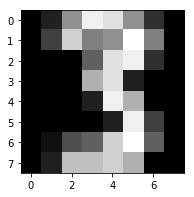

In [6]:
i = 13
plt.imshow(digits.images[i], cmap='gray')
print("id: ", i,", target: ", digits.target[i])

We now use one of scikit-learn's estimators classes in order to predict the digit from an image. 

Here we use an SVC (support vector machine classification) classifier, which uses a part of the dataset (the **training set**) to find the best way to separate the different classes. Even without knowing the details of the SVC, we can use it as a black box thanks to the common estimator API of scikit-learn. An estimator is created by initializing an estimator object: 

In [7]:
from sklearn import svm
clf = svm.SVC(gamma=0.001, C=100.)

The estimator is trained from the learning set using its ``.fit`` method. We train on the first half of the dataset.

In [8]:
train_ids=np.arange(0,1797//2)   # Use first half for training
test_ids=np.arange(1797//2,1797) # Use second half for testing
clf.fit(digits.data[train_ids], digits.target[train_ids])

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Then the target value of new data is predicted using the ``.predict`` method of the estimator. We predict within the second half of the dataset to avoid predicting on the data used for training.

[8 9 8]


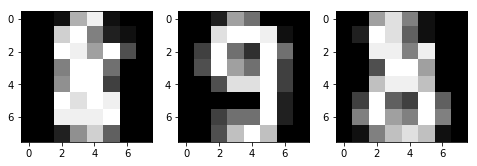

In [9]:
print(clf.predict(digits.data[-3:]))
fig, axes = plt.subplots(1, 3)
axes[0].imshow(digits.images[-3], cmap='gray')
axes[1].imshow(digits.images[-2], cmap='gray')
axes[2].imshow(digits.images[-1], cmap='gray')

Compute the overall performance by predicting over all the testing samples

In [11]:
prediction = clf.predict(digits.data) # predict on everything
correct = sum(prediction[test_ids]==digits.target[test_ids]) # But compute perf on test only
tot  = test_ids.size
accuracy=correct/tot
print('accuracy = {:.3} (correct={}/tot={})'.format(accuracy, correct,tot))

accuracy = 0.97 (correct=872/tot=899)


In [12]:
from ipywidgets import IntSlider, interact
@interact(N=IntSlider(min=0,max=digits.target.size-1,value=0))
def display_prediction(N=0):
    target=digits.target
    nb=target.size
    i=N#idsW[N]
    fig, axes = plt.subplots(1,2,figsize=(12,3))
    plt.sca(axes[0])
    plt.imshow(digits.images[i], cmap='gray')
    if (prediction[i]==target[i]):
        col='green'
    else:
        col='red'
    plt.title("#{}:\n{}/{}".format(i,prediction[i],digits.target[i]), color=col)
    plt.xticks([]);  plt.yticks([])
    plt.sca(axes[1])
    delta=100
    r0=max(0,i-delta)
    r1=r0+delta*2
    r=range(r0,r1+1)
    plt.plot([i,i],[-0.5,9.5],'y')
    plt.plot(r,target[r],'ob')
    plt.plot(r,prediction[r],'.r')
    plt.xlim(r0-0.5,r1+0.5); plt.xlabel('sample #')
    plt.ylim(-0.5,9.5); plt.ylabel('label')

interactive(children=(IntSlider(value=0, description='N', max=1796), Output()), _dom_classes=('widget-interact',))

Let's display all incorrect predictions and some corretc ones

In [13]:
id0=1000
ids=range(id0,id0+100)

#ids=test_ids[np.nonzero(prediction[test_ids]!=digits.target[test_ids])]
#ids=np.array(np.nonzero(prediction!=digits.target))
#(prediction==digits.target)
idsW=np.nonzero(prediction!=digits.target)[0]
idsC=np.nonzero(prediction==digits.target)[0]
nbW=idsW.size
if (nbW>=50):
    ids = np.concatenate((idsW[:50],idsC[-50:]))
else:
    ids = np.concatenate((idsW[:],idsC[-(100-nbW):]))

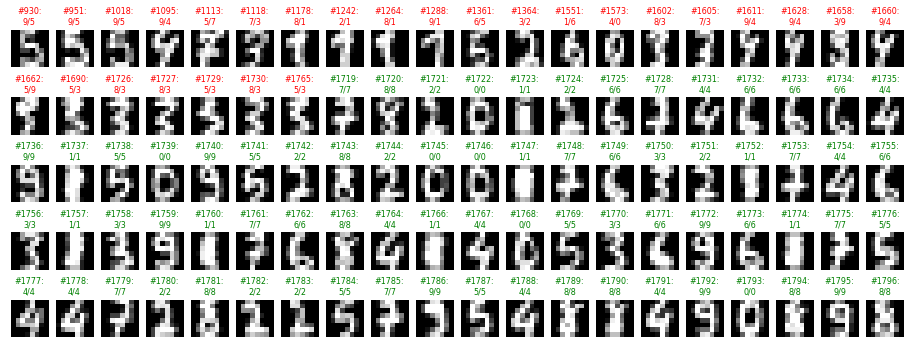

In [14]:
fig, axes = plt.subplots(5,20, figsize=(16,6))
for ax in axes.ravel():
    ax.set_xticks([]); ax.set_yticks([]); ax.set_frame_on(False)
for i,ax in zip(ids,axes.ravel()):
    ax.imshow(digits.images[i],cmap='gray')
    p=clf.predict(digits.data[[i],:])
    if (p[0]==digits.target[i]):
        col='green'
    else:
        col='red'
    ax.set_title("#{}:\n{}/{}".format(i,p[0],digits.target[i]), dict(fontsize=8,color=col))
    ax.set_xticks([]);  ax.set_yticks([])

So far, so good? We completed our first machine learning example!

In the following, we will see how to use machine learning for image processing. We will use different kinds of samples and features, starting from low-level pixel-based features (e.g. RGB color), to mid-level features (e.g. corner, patches of high contrast), and finally to properties of segmented regions. 

## Supervised learning of segmentation

### Learning color segmentation

__Beach segmentation__

In the following example, we define manually a mask that defines 3 training labels: forest, sky+water, sand. By default, pixels at 0 correspond to unlabeled pixels.

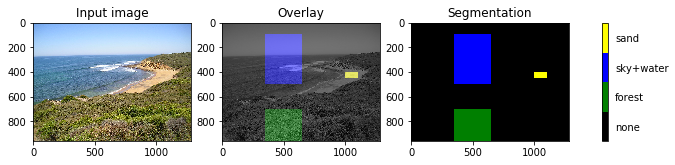

In [15]:
from skimage import io, color
import numpy as np
import matplotlib.pyplot as plt
from skdemo import show_segmentation

# Image from https://fr.wikipedia.org/wiki/Fichier:Bells-Beach-View.jpg
beach = io.imread('../images/Bells-Beach.jpg')
#plt.imshow(beach)

# Define mask of user-labeled pixels, which will be used for training
mask = np.zeros(beach.shape[0:2], dtype=np.uint8)
mask[700:, 350:650] = 1
mask[100:500, 350:650] = 2
mask[400:450, 1000:1100] = 3

colors=[[0,0,0],[0,0.5,0],[0,0,1],[1,1,0]]
labels=['none','forest','sky+water','sand']

#plt.imshow(color.label2rgb(mask, beach, colors=colors))
show_segmentation(beach, mask, colors, labels)

In [16]:
# # Uncomment this to separate sky and water
# mask = np.zeros(beach.shape[0:2], dtype=np.uint8)
# mask[700:, 350:650] = 1
# mask[100:500, 350:650] = 2
# mask[400:450, 1000:1100] = 3
# mask[0:250, 450:750] = 4
# mask[300:500, 350:650] = 2
# colors=[[0,0,0],[0,0.5,0],[0,0,1],[1,1,0],[0,1,1]]
# labels=['none','forest','water','sand','sky']
# show_segmentation(beach, mask, colors, labels)

In [17]:
# # Uncomment this if the image is too large and processing takes too long
# subk=2
# beach2 = transform.rescale(beach, 1/subk) 
# mask2 = np.zeros(beach2.shape[0:2], dtype=np.uint8)
# mask2[:,:]=mask[::subk,::subk]
# beach=beach2
# mask=mask2

We define a segmentation algorithms which:
- uses the **RGB color channels** for each pixel as feature
- trains a **RandomForest** classifier from user-labeled data, which are given as a mask of labels
- and predicts the label on all the image

The RandomForest algorithm chooses automatically thresholds along the different feature directions, and also decides which features are the most significant to discriminate between the different classes. This is very useful when we don't know if all features are relevant.

In [18]:
from sklearn.ensemble import RandomForestClassifier
#from sklearn.svm import LinearSVC

def trainable_segmentation(im_features, mask, reuseTraining=False):
    """
    Parameters
    ----------

    im_features: ndarray of size [height,width,nb_features], 
        Feature map
    
    mask : ndarray of ints
        Array of labels. Non-zero labels are known regions that are used
        to train the classification algorithm.
        
    reuseTraining: bool
        use training mask 
    """
    # Define features
    im_features = np.atleast_3d(im_features)
    nb_row, nb_col, nb_features = im_features.shape
    
    # Training data correspond to pixels labeled in mask
    nb_training = (mask>0).sum()
    training_data = im_features[mask>0, :]
    training_data = training_data.reshape(nb_training, nb_features)
    training_labels = mask[mask>0].ravel()
    
    # Training
    print('Training...')
    clf = RandomForestClassifier()
    #clf = LinearSVC()
    clf.fit(training_data, training_labels)
    
    # Prediction
    print('Predicting...')
    if reuseTraining:
        # Predict only on non-training pixels
        nb_nontraining = (mask == 0).sum()
        data = im_features[mask == 0, :].reshape(nb_nontraining, nb_features)
        labels = clf.predict(data)
        result = np.copy(mask)
        result[mask == 0] = labels
    else:
        # Predict on all pixels (even already labeled ones)
        labels = clf.predict(im_features.reshape(nb_row*nb_col, nb_features))
        result = labels.reshape(mask.shape)
    return result

Let's apply this supervised classification...

Training...
Predicting...


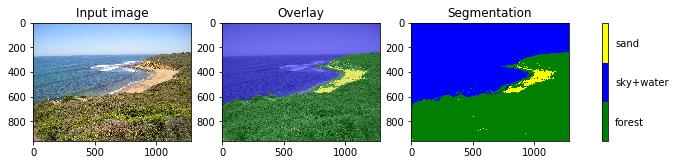

In [19]:
result_rgb = trainable_segmentation(beach, mask)
show_segmentation(beach, result_rgb, colors[1:], labels=labels[1:])

We notice that the labels have been extended to all the pixels in the image.

If we would ignore the provided labels and run unsupervised K-means instead, here is what we would get. 

Water and sky seem to be identified fine, but sand and forest are not separated.

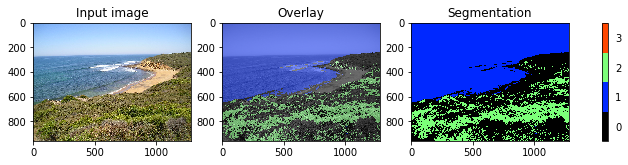

In [20]:
from sklearn.cluster import KMeans
from skimage import segmentation
data=color.rgb2lab(beach).reshape(-1,3)[:,1:3]
kmeans = KMeans(n_clusters=3, random_state=1).fit(data)
result = 1+kmeans.labels_.reshape(beach.shape[:2]) # Add 1 so that label 0 means 'no label'
show_segmentation(beach, result, cmap='gray')

__Segment the Zebra__

Let's try on another example

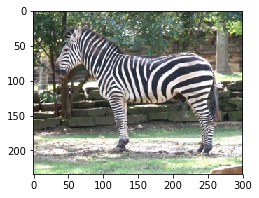

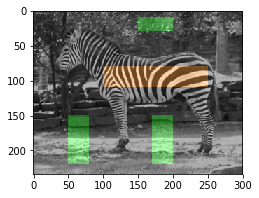

In [22]:
zebra = io.imread('../images/zebra.jpg')
plt.imshow(zebra)

zmask = np.zeros(zebra.shape[0:2], dtype=np.uint8)
zmask[80:110, 100:250] = 1
zmask[150:220, 50:80] = 2
zmask[10:30, 150:200] = 2
zmask[150:220, 170:200] = 2

colors=[[0,0,0],[1,0.5,0],[0,1,0]]
labels=['none','zebra','background']
plt.figure()
plt.imshow(color.label2rgb(zmask, zebra, colors=colors))

Training...
Predicting...


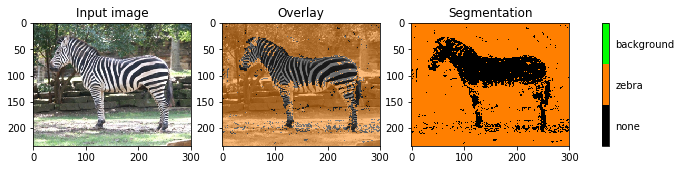

In [23]:
result = trainable_segmentation(zebra, zmask)
show_segmentation(zebra, result, colors, labels)

Using only RGB color, the classification has only very little information to decide if a pixel belong to the zebra or not, hence the noisy aspect of the segmentation.

### Increasing the number of features
To get more information, we can preprocess the image with various filters to associate different type of information. For instance, with a scale-space, each pixel receives also the color of images filtered at different scales, which depends on the local neighourood. The decision then does not need to be based on the color of this pixel alone, but also takes into account the average color around the pixel.

In [24]:
from skimage import filters

def compute_features_scalespace(im, sigmas=[1/2,1,2,4], with_sobel=False):
    im = np.atleast_3d(im)
    nb_scales = len(sigmas)
    nb_channels = im.shape[2]
    #sigmas = np.logspace(omin,omax, num=nb_scales, base=2)
    im_size = im.shape[:2]
    im_features = np.empty((im.shape[0], im.shape[1], nb_scales*nb_channels))
    for i,s in enumerate(sigmas):
        tmp = filters.gaussian(im,s, multichannel=True)
        im_features[:,:,i:i+nb_scales*nb_channels:nb_scales] = tmp
    if with_sobel:
        for i in range(im_features.shape[2]):
            edges = np.atleast_3d(filters.sobel(im_features[:,:,i]))
            im_features=np.concatenate((im_features, edges), axis=2)
            #im_features[:,:,[i]]=edges
    return im_features

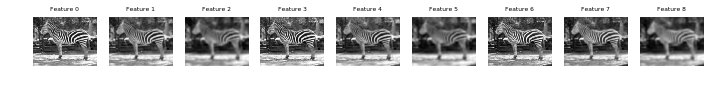

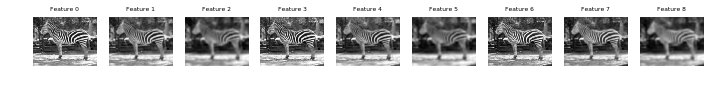

In [25]:
zfeatures = compute_features_scalespace(zebra, sigmas=[1,2,4])  
show_features(zfeatures, nx=9)

By combining this with Lab color space, we obtain a set of diverse features that are suitable for more complex segmentation rules, as it combines both **color and spatial information**:

Training...
Predicting...


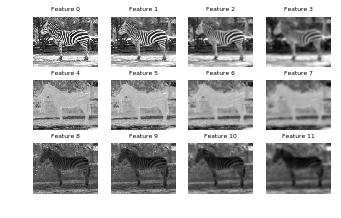

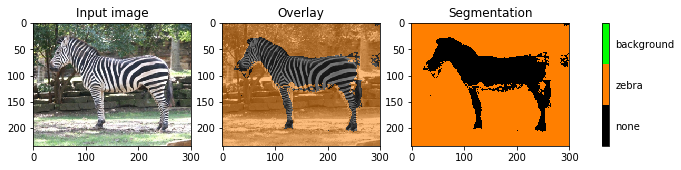

In [26]:
zfeatures = compute_features_scalespace(color.rgb2lab(zebra), sigmas=[1/2,1,2,4])  
show_features(zfeatures, nx=4)
result = trainable_segmentation(zfeatures, zmask)
show_segmentation(zebra, result, colors, labels)

### Texture features

In the examples above, a small number of features per pixel was used: either a color triplet only, or a color triplet and its (x, y) position. However, it is possible to use other features, such as the local texture. Texture features can be obtained using Gabor filters, which are Gaussian kernels modulated by a sinusoidal wave. 

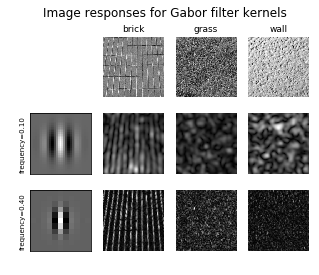

In [27]:
# From http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_gabor.html
from skimage import data, img_as_float
from skimage.filters import gabor_kernel
import scipy.ndimage as ndi

shrink = (slice(0, None, 3), slice(0, None, 3))
brick = img_as_float(data.load('brick.png'))[shrink]
grass = img_as_float(data.load('grass.png'))[shrink]
wall = img_as_float(data.load('rough-wall.png'))[shrink]
image_names = ('brick', 'grass', 'wall')
images = (brick, grass, wall)


def power(image, kernel):
    # Normalize images for better comparison.
    image = (image - image.mean()) / image.std()
    return np.sqrt(ndi.convolve(image, np.real(kernel), mode='wrap')**2 +
                   ndi.convolve(image, np.imag(kernel), mode='wrap')**2)

# Plot a selection of the filter bank kernels and their responses.
results = []
kernel_params = []
for frequency in (0.1, 0.4):
    kernel = gabor_kernel(frequency, theta=0)
    params = 'frequency=%.2f' % (frequency)
    kernel_params.append(params)
    # Save kernel and the power image for each image
    results.append((kernel, [power(img, kernel) for img in images]))

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(5, 4))
plt.gray()

fig.suptitle('Image responses for Gabor filter kernels', fontsize=12)

axes[0][0].axis('off')

# Plot original images
for label, img, ax in zip(image_names, images, axes[0][1:]):
    ax.imshow(img)
    ax.set_title(label, fontsize=9)
    ax.axis('off')

for label, (kernel, powers), ax_row in zip(kernel_params, results, axes[1:]):
    # Plot Gabor kernel
    ax = ax_row[0]
    ax.imshow(np.real(kernel), interpolation='nearest')
    ax.set_ylabel(label, fontsize=7)
    ax.set_xticks([])
    ax.set_yticks([])

    # Plot Gabor responses with the contrast normalized for each filter
    vmin = np.min(powers)
    vmax = np.max(powers)
    for patch, ax in zip(powers, ax_row[1:]):
        ax.imshow(patch, vmin=vmin, vmax=vmax)
        ax.axis('off')

We define a segmentation algorithms which:
- computes different **texture features using Gabor filters** of different scale and angle, for every pixel
- trains a **RandomForest** classifier from user-labeled data, which are given as a mask of labels
- and predicts the label of the remaining non-labeled pixels

The Gabor features provides the classifier with more information that just the color, as they capture also the texture aspect in the image.

In [28]:
from skimage import filters
from skimage import img_as_float

def compute_features_gabor(im, thetas=[0, np.pi/2], gabor_frequencies=None):
    if (gabor_frequencies is None):
        gabor_frequencies = np.logspace(-3, 0, num=4, base=2)
    nb_fq = len(gabor_frequencies) * len(thetas)
    im = np.atleast_3d(im)
    nb_ch=im.shape[-1]
    im_size = im.shape[:2]
    im_gabor = np.empty(im_size + (nb_ch, nb_fq))
    for ch in range(nb_ch):
        img = img_as_float(im[..., ch])
        for i_fq, fq in enumerate(gabor_frequencies):
            for i_th, theta in enumerate(thetas):
                tmp = filters.gabor(img, fq, theta=theta)
                im_gabor[:,:, ch, len(thetas) * i_fq + i_th] = \
                                    np.abs(tmp[0] + 1j * tmp[1])
    im_gabor = im_gabor.reshape((im_size[0],im_size[1],nb_ch*nb_fq))
    return im_gabor

Let's apply this to segment a textured image

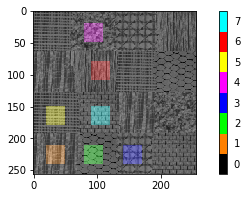

In [29]:
# Load textured patch (source http://w3.ualg.pt/~dubuf/pubdat/texture/texture.html)
patch = io.imread('../images/patch3.gif')
plt.imshow(patch)

from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable

pmask = np.zeros(patch.shape[0:2], dtype=np.uint8)
pmask[210:240, 20:50] = 1
pmask[210:240, 80:110] = 2
pmask[210:240, 140:170] = 3
pmask[20:50, 80:110] = 4
pmask[150:180, 20:50] = 5
pmask[80:110, 90:120] = 6
pmask[150:180, 90:120] = 7

colors=[[0,0,0],[1,0.5,0],[0,1,0],[0,0,1],[1,0,1],[1,1,0],[1,0,0],[0,1,1]]
labels=['none','1','2','3','4','5','6','7']
plt.imshow(color.label2rgb(pmask, patch, colors=colors))
discrete_colorbar(colors)

__Approach 1:__ Classification based on gray level only... 

Training...
Predicting...


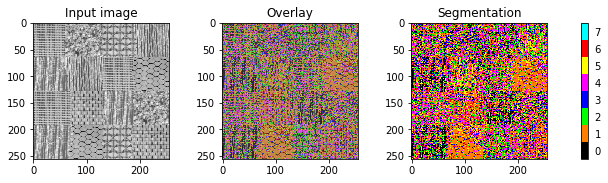

In [30]:
result = trainable_segmentation(patch, pmask)
show_segmentation(patch, result, colors, cmap='gray')

Most patches have similar gray levels, so gray-level only can not discriminate between them.

__Approach 2:__ Classification based on gaussian scale-space.

Training...
Predicting...


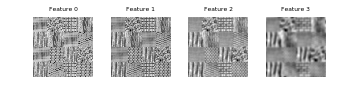

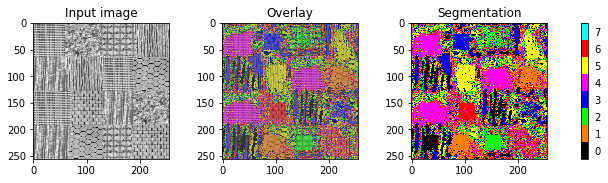

In [31]:
pfeatures = compute_features_scalespace(patch, sigmas=[1/2,1,2,4], with_sobel=False)
show_features(pfeatures)
result = trainable_segmentation(pfeatures, pmask)
show_segmentation(patch, result, colors, cmap='gray')

Some classes are partially detected (2, 5, 6 mostly). The rest is still quite mixed.

__Approach 3:__ Classification based on Gabor texture features.

Training...
Predicting...


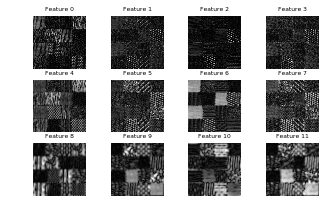

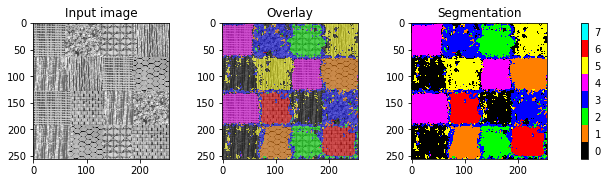

In [32]:
pfeatures = compute_features_gabor(patch, thetas=[0, np.pi/4, np.pi/2, np.pi*3/4], gabor_frequencies=[1/2,1/4,1/8])
#pfeatures = np.concatenate((pfeatures, compute_features_scalespace(patch)),axis=2)
show_features(pfeatures, nx=4)
result = trainable_segmentation(pfeatures, pmask)
show_segmentation(patch, result, colors, cmap='gray')

The Gabor features extracts the most relevant visual information for recognizing the various textures compared to scale-space and gray-level features. Although the boundaries are not very precise, most of each patch is correctly classified.

The set of visual features to use is dependent on the problem. For recognizing sand, forest and water, the color features worked well; for recognizing textures, Gabor features work better.

__Comparison with clustering:__ As a side note, could this segmentation be found using only unsupervised segmentation with K-Means? 

After clustering, we can recognize the patch regions, but we notice both oversegmentation (class 5 split into clusters 3 and 5) and undersegmentation (cluster 4 overlaps classes 2, 3, 4 and a bit of 7). If there is not an obvious difference in feature space between the clusters that unsupervised classification could detect, supervised classification is needed to produce a segmentation that makes sense.

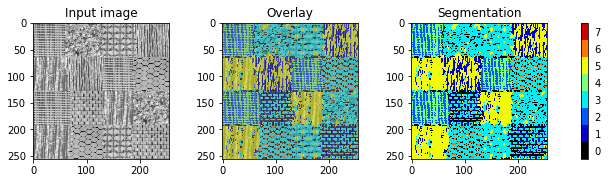

In [33]:
from sklearn.cluster import KMeans
from skimage import segmentation
data = pfeatures.reshape(-1,pfeatures.shape[-1])
kmeans = KMeans(n_clusters=7, random_state=5).fit(data)
result = 1+kmeans.labels_.reshape(patch.shape) # Add 1 so that label 0 means 'no label'
show_segmentation(patch, result, colors=None, cmap='gray')